## <b style="color:Green;">Graph Creation</b>
used to create a graph data structure for the selected nodes

### <b> Importing Libraries </b>

In [744]:
%reset

In [745]:
import pickle
import pandas as pd
import torch
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader

### <b> Importing data and preprocessing </b>

In [750]:
user_data=pd.read_csv("data/musae_git_target.csv")
selected_nodes=pickle.load(open("data/selected_nodes.pkl","rb"))
edge_data=pd.read_csv("data/musae_git_edges.csv")

In [751]:
selected_nodes.drop(["index"],axis=1,inplace=True)
selected_nodes["id"]=selected_nodes["id"].astype("int")
selected_nodes["ml_target"]=selected_nodes["id"].apply(lambda idx : user_data.iloc[idx]["ml_target"])

In [752]:
selected_nodes.loc[selected_nodes["id"]==33262]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,id,ml_target
29159,2589,1515,3214,1953,3129,3077,364,1171,1022,2045,536,1563,2449,1532,3771,33262,0


### <b> Graph Gen Logic 1 </b>
* lets take 1000 developers , that is 1000 graphs with 10 nodes 
* logic : Get the first level of connection for a node if not suffient no. of nodes acquired then go for the second level
* then we'll train the network based on it

<b> Update Needed : select only the nodes which is from the selected_nodes ,i.e nodes which with >= 15 features </b> <br>
    update done in next cell

[[12, 12, 12, 12, 12, 12, 11051, 11051, 11051], [20854, 4398, 9598, 25134, 13228, 11051, 37683, 16039, 13744]]
10
Developer's Name : damianmuti


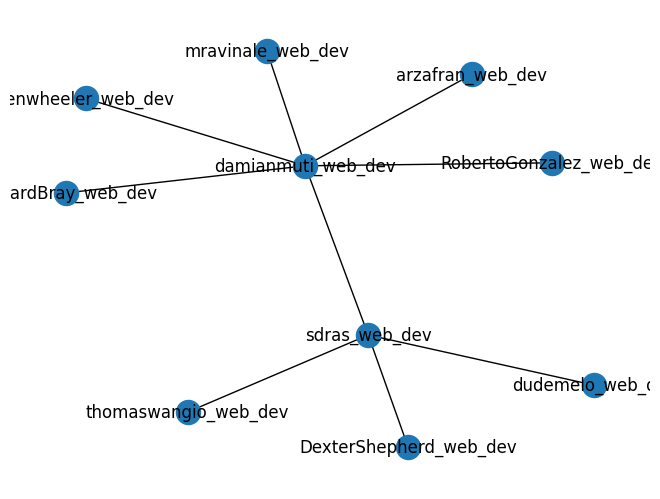

In [518]:
edge_index=[[],[]]
nodes_parsed=[]
def generate_graph(dev_id,nodes_needed):
    neighbour_dev_ids=edge_data.loc[edge_data["id_1"]==dev_id]["id_2"].values
    for neighbour_dev in neighbour_dev_ids:
        if len(set([item for sublist in edge_index for item in sublist]))>=10:
            break
        else:
            edge_index[0].append(dev_id),edge_index[1].append(neighbour_dev)
    nodes_parsed.append(dev_id)
    nodes=set([item for sublist in edge_index for item in sublist])
    if len(nodes)>=nodes_needed:
        return edge_index
    else:
        dev_id = list(set(nodes) - set(nodes_parsed))[0]
        nodes_needed-=len(neighbour_dev_ids)+1 #why plus 1 because of the current node 
        return generate_graph(dev_id,nodes_needed)

dev_id=int(input("Enter Dev Id : "))


result=generate_graph(dev_id,10)
print(result)
nodes=set([item for sublist in result for item in sublist])
print(len(nodes))



### Visualization

dev_name=user_data.loc[user_data["id"]==dev_id]["name"].values[0]
print("Developer's Name :",dev_name)
Graph=nx.Graph()
for source,dest in zip(result[0],result[1]):
    src_name,dest_name=user_data.loc[user_data["id"]==source]["name"].values[0],user_data.loc[user_data["id"]==dest]["name"].values[0]
    src_domain,dest_domain=user_data.loc[user_data["id"]==source]["ml_target"].values[0],user_data.loc[user_data["id"]==dest]["ml_target"].values[0]
    if src_domain==1:
        src_domain="ML_dev"
    else:
        src_domain="web_dev"
    if dest_domain==1:
        dest_domain="ML_dev"
    else:
        dest_domain="web_dev"
    src,dest=src_name+"_"+src_domain,dest_name+"_"+dest_domain
    Graph.add_edge(src,dest)
nx.draw(Graph,with_labels=True)

### <b> Graph Gen Logic 1 Bug fixed </b>
* selecting only the nodes which has a feature size of more than 15 --> bug in the previous 
* previously we had considering the friendship between two devs only if there is a connection from id1 to id2 
* but from the document it is clear that it is not directed from id1 to id2  the vice verse is also considered as a valid connection and the following code adopts to that change

In [753]:
selected_nodes_ids=list(selected_nodes["id"])

# edge_index_mapping=[[],[]]
# nodes_parsed=[] 

# the above two lines (edge_index_mapping and nodes_parsed) needs to be enabled if you are running this cell alone or else we may face a data repeatation error while generating graphs due to the line 12
"""
why so ?
for first time of the iteration in generating multiple graphs for different users (below call) the edge_index_mapping will
get some values for the first iteration and then that will get repeated again and again beacause of the line 14 in this cell 
"""


def generate_graph(dev_id,nodes_needed):
    neighbour_dev_ids=list(edge_data.loc[edge_data["id_1"]==dev_id]["id_2"].values)+list(edge_data.loc[edge_data["id_2"]==dev_id]["id_1"].values)
    neighbour_dev_ids=list(set(neighbour_dev_ids))
    still_needed=0
    for neighbour_dev in neighbour_dev_ids:
        if len(set([item for sublist in edge_index_mapping for item in sublist]))>=10:
            break
        else:
            if dev_id in selected_nodes_ids and neighbour_dev in selected_nodes_ids:
                edge_index_mapping[0].append(dev_id),edge_index_mapping[1].append(neighbour_dev)
                still_needed+=1
            else:
                pass
                
    nodes_parsed.append(dev_id)
    nodes=set([item for sublist in edge_index_mapping for item in sublist])
    if len(nodes)>=nodes_needed:
        return edge_index_mapping
    else:
        dev_id = list(set(nodes) - set(nodes_parsed))[0]
        nodes_needed-=still_needed+1 #why plus 1 because of the current node 
        return generate_graph(dev_id,nodes_needed)



"""
The below code is used to visualize graph generated by the above code if you wanna use the below visualization kindly uncomment the above two lines also
"""
# dev_id=int(input("Enter Dev Id : "))


# result=generate_graph(dev_id,10)
# print(result)
# nodes=set([item for sublist in result for item in sublist])
# print(len(nodes))



# ### Visualization

# dev_name=user_data.loc[user_data["id"]==dev_id]["name"].values[0]
# print("Developer's Name :",dev_name)
# Graph=nx.Graph()
# for source,dest in zip(result[0],result[1]):
#     src_name,dest_name=user_data.loc[user_data["id"]==source]["name"].values[0],user_data.loc[user_data["id"]==dest]["name"].values[0]
#     src_domain,dest_domain=user_data.loc[user_data["id"]==source]["ml_target"].values[0],user_data.loc[user_data["id"]==dest]["ml_target"].values[0]
#     if src_domain==1:
#         src_domain="ML_dev"
#     else:
#         src_domain="web_dev"
#     if dest_domain==1:
#         dest_domain="ML_dev"
#     else:
#         dest_domain="web_dev"
#     src,dest=src_name+"_"+src_domain,dest_name+"_"+dest_domain
#     Graph.add_edge(src,dest)
# nx.draw(Graph,with_labels=True)


### <b> Making a dataset </b>
* lets take 700 ML devs and 700 web devs and make a graph structures for them <br>

In [754]:
web_samples = selected_nodes[selected_nodes['ml_target'] == 0].sample(700, random_state=42)
ml_samples = selected_nodes[selected_nodes['ml_target'] == 1].sample(700, random_state=42)
train_samples=pd.concat([web_samples,ml_samples],axis=0)

In [755]:
graph_datasets = []
for sample in train_samples.iterrows():
    edge_index_mapping=[[],[]]
    nodes_parsed=[]
    dev_id=sample[1]["id"]
    try:
        # print("$$$ Dev ID $$$",dev_id)
        edge_idx=generate_graph(dev_id,10)
        # print("$$$ Edge Index $$$",edge_idx)
    except IndexError:
        print('Not enough eligibile neighbours* to create a graph') # eligible neighbours --> neighbours with 15 features
        continue
    nodes=set([ele for sublist in edge_idx for ele in sublist])
    mappings=dict(enumerate(nodes))
    # print("$$$ Mappings $$$",mappings)
    # # #replace edge_idx with mapped number and put values data.x according
    data_x=[] #user to store the vector of each node the end shape of this will no. of nodes * vector length
    labels=[] #used to store the label for each node
    # print("$$$ Mappings $$$",mappings)
    for map,idx in mappings.items():
        label=user_data.loc[user_data["id"]==idx]["ml_target"].values[0]
        labels.append(label)
        
        data_x.append(list(selected_nodes.loc[selected_nodes["id"]==idx][list(range(15))].values[0]))
    
    mapping_inverse={value:key for key,value in mappings.items()}
    # print("$$$ Mappings Inverse $$$",mapping_inverse)

    edge_idx_tensor=[list(range(len(edge_idx[0]))),list(range(len(edge_idx[1])))]
    for i in range(len(edge_idx)):
        for j in range(len(edge_idx[i])):
            edge_idx_tensor[i][j]=mapping_inverse[edge_idx[i][j]]
    # print("$$$ Data_x $$$",data_x)
    # print("$$$ Edge_idx_tensor $$$",edge_idx_tensor)
    
    graph = Data(x=torch.Tensor(data_x), edge_index=torch.tensor(edge_idx_tensor).long(), y=torch.tensor(labels))
    # print(graph)
    graph_datasets.append(graph)
    # break


Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours* to create a graph
Not enough eligibile neighbours

In [764]:
idx=1238
graph_datasets[idx].edge_index,graph_datasets[idx].y

(tensor([[7, 9, 9, 9, 9, 9, 9, 2, 2, 2],
         [9, 2, 4, 5, 6, 7, 8, 0, 1, 3]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1]))

In [765]:
loader = DataLoader(graph_datasets, batch_size=10, shuffle=True) # splitting with the batch size of 2

c:\Users\rbw19\OneDrive\Desktop\GNN_guide\graph_venv\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [766]:
pickle.dump(graph_datasets,open("data/graphs.pkl","wb"))

In [740]:
pickle.dump(loader,open("data/graph_data_generated.pkl","wb"))
# Need to look into some method to save the DataLoader object

PicklingError: Can't pickle <class 'torch_geometric.deprecation.DataLoader'>: attribute lookup DataLoader on torch_geometric.deprecation failed

In [767]:
# Iterate over batches
for batch in loader:
    print("Batch:")
    print("Number of graphs in the batch:", batch.num_graphs)
    print("Node features shape:", batch.x.shape)
    print("Edge indices shape:", batch.edge_index.shape)
    print("Node labels shape:", batch.y.shape)
    print()


Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([100, 15])
Edge indices shape: torch.Size([2, 90])
Node labels shape: torch.Size([100])

Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([100, 15])
Edge indices shape: torch.Size([2, 93])
Node labels shape: torch.Size([100])

Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([97, 15])
Edge indices shape: torch.Size([2, 88])
Node labels shape: torch.Size([97])

Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([98, 15])
Edge indices shape: torch.Size([2, 91])
Node labels shape: torch.Size([98])

Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([100, 15])
Edge indices shape: torch.Size([2, 94])
Node labels shape: torch.Size([100])

Batch:
Number of graphs in the batch: 10
Node features shape: torch.Size([94, 15])
Edge indices shape: torch.Size([2, 87])
Node labels shape: torch.Size([94])

Batch:
Number of graphs in the bat